In [1]:
from notebooks.util.distribution_utils import *
from hurst_exponent.util.utils import augmented_dickey_fuller
from liquidity.response_functions.features import compute_aggregate_features

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Bin/window size for computing events
T = 1000

## Load market orders raw sample data

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

In [5]:
tsla_raw_df

,Unnamed: 0,event_timestamp,trade_sign,side,lob_action,order_executed,execution_price,execution_size,ask,bid,midprice,ask_volume,bid_volume,price_changing,midprice_change,R1,norm_trade_volume
0,0,2016-01-04 10:30:02.487834868,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
1,1,2016-01-04 10:30:02.594369706,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,100.0,100.0,True,0.000,-0.000,0.708122
2,2,2016-01-04 10:30:02.602151380,-1,BID,REMOVE,True,221.36,100,221.46,221.36,221.410,200.0,100.0,True,-0.095,0.095,0.708122
3,3,2016-01-04 10:30:02.627167275,-1,BID,REMOVE,True,221.27,25,221.36,221.27,221.315,200.0,25.0,True,-0.010,0.010,0.177031
4,4,2016-01-04 10:30:02.895123534,-1,BID,REMOVE,True,221.25,100,221.36,221.25,221.305,100.0,100.0,True,-0.090,0.090,0.708122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757587,757587,2016-12-30 14:57:34.003070849,-1,BID,REMOVE,True,212.66,78,212.71,212.66,212.685,100.0,78.0,True,-0.045,0.045,0.523301
757588,757588,2016-12-30 14:57:49.675498708,1,ASK,REMOVE,True,212.70,100,212.70,212.58,212.640,100.0,3.0,True,0.015,0.015,0.764442
757589,757589,2016-12-30 14:57:50.825570371,1,ASK,REMOVE,True,212.73,118,212.73,212.58,212.655,118.0,3.0,True,-0.005,-0.005,0.902041
757590,757590,2016-12-30 14:58:02.190130229,1,ASK,REMOVE,True,212.72,100,212.72,212.58,212.650,100.0,3.0,True,0.035,0.035,0.764442


## 1. Orderflow

### 1.1. Size/ Volume

In [6]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_trade_volume'],
               'MSFT': amzn_raw_df['norm_trade_volume'],
               'AMZN': nflx_raw_df['norm_trade_volume'],
               'NFLX': msft_raw_df['norm_trade_volume'],
               'EBAY': ebay_raw_df['norm_trade_volume'],
               'APPL': appl_raw_df['norm_trade_volume'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [7]:
# ADF test
for stock, data in size_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -56.98
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -54.80
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -74.32
p-value: 0.00,
N: 499928, 
critical values: {'1%': -3.4303630805507535, '5%': -2.861545781449468, '10%': -2.5667730772543624}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -52.22
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



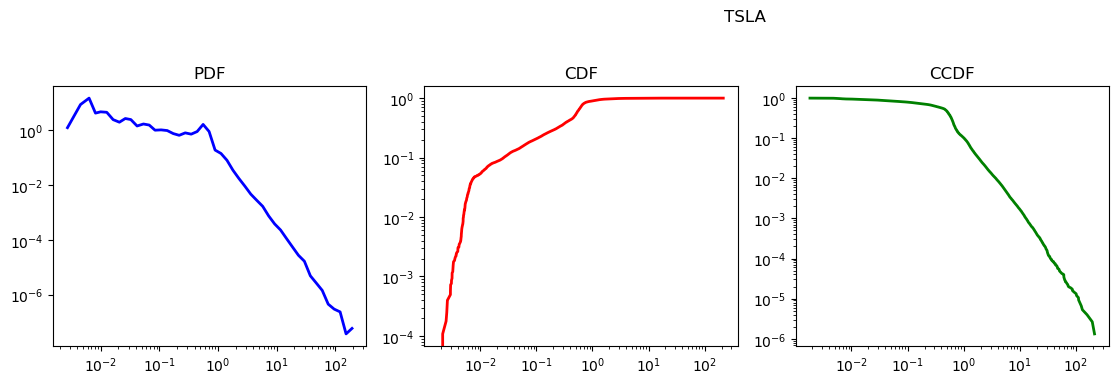

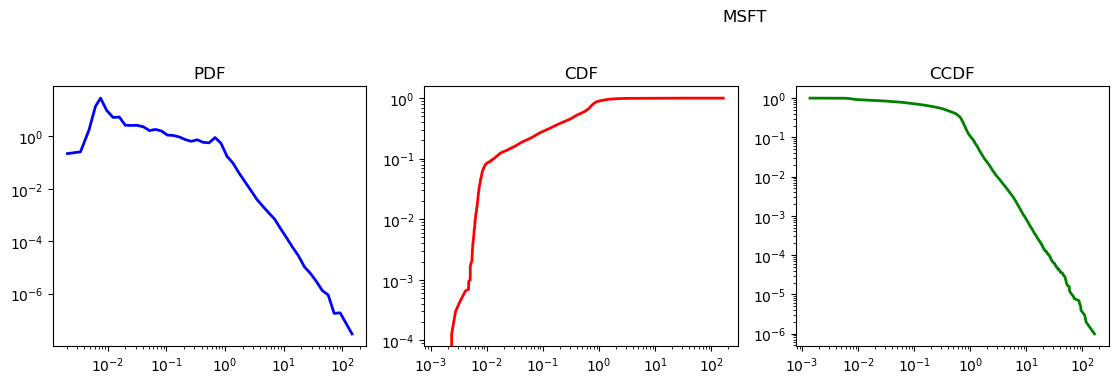

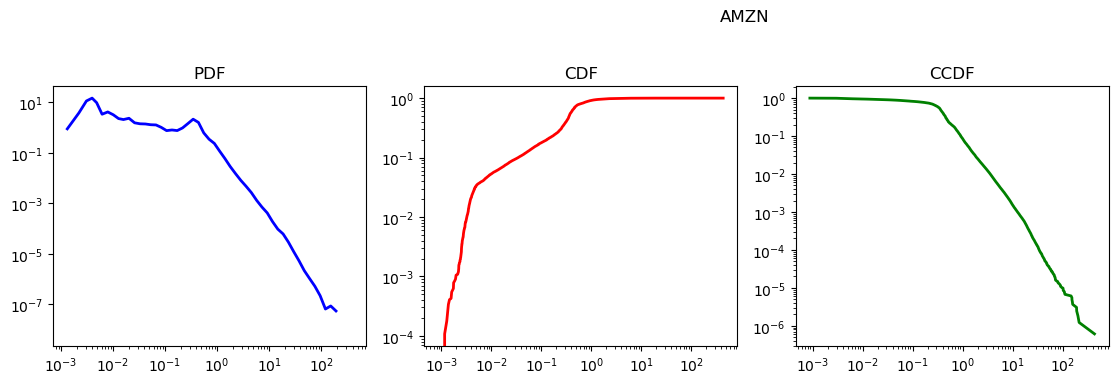

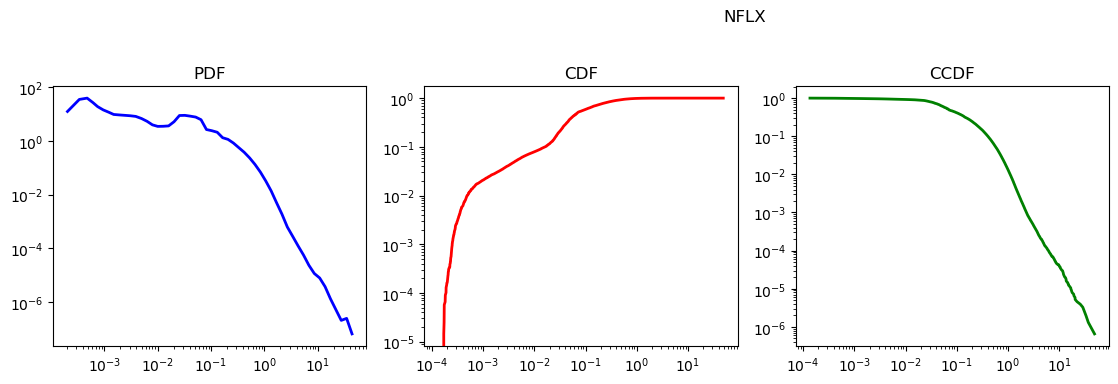

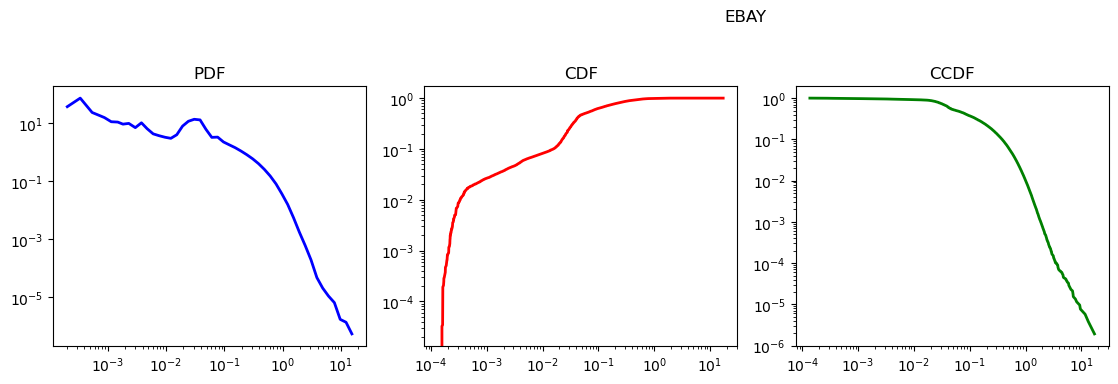

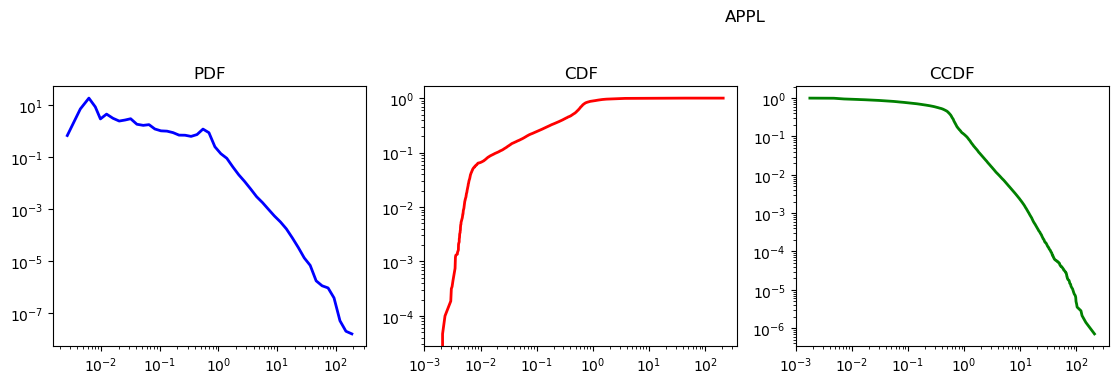

In [8]:
# Plot distribution of size_volume for each stock
for stock_name, data in size_volume.items():
    plot_distributions(stock_name, data)

### 1.2. Fit power law distribution

In [9]:
# 1. Fit Powerlaw and retrieve fitted object/ results
size_volume_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_size_volume_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(size_volume_data):
    volume_fit_objects = fit_powerlaw(data_dict=size_volume, filename=size_volume_data)
else:
    volume_fit_objects = load_fit_objects(size_volume_data)

volume_fit_objects

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x28a2b77d0>,
 'MSFT': <powerlaw.Fit at 0x289a481d0>,
 'AMZN': <powerlaw.Fit at 0x289e6b010>,
 'NFLX': <powerlaw.Fit at 0x1680d3cd0>,
 'EBAY': <powerlaw.Fit at 0x289a43610>,
 'APPL': <powerlaw.Fit at 0x289eb62d0>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution give

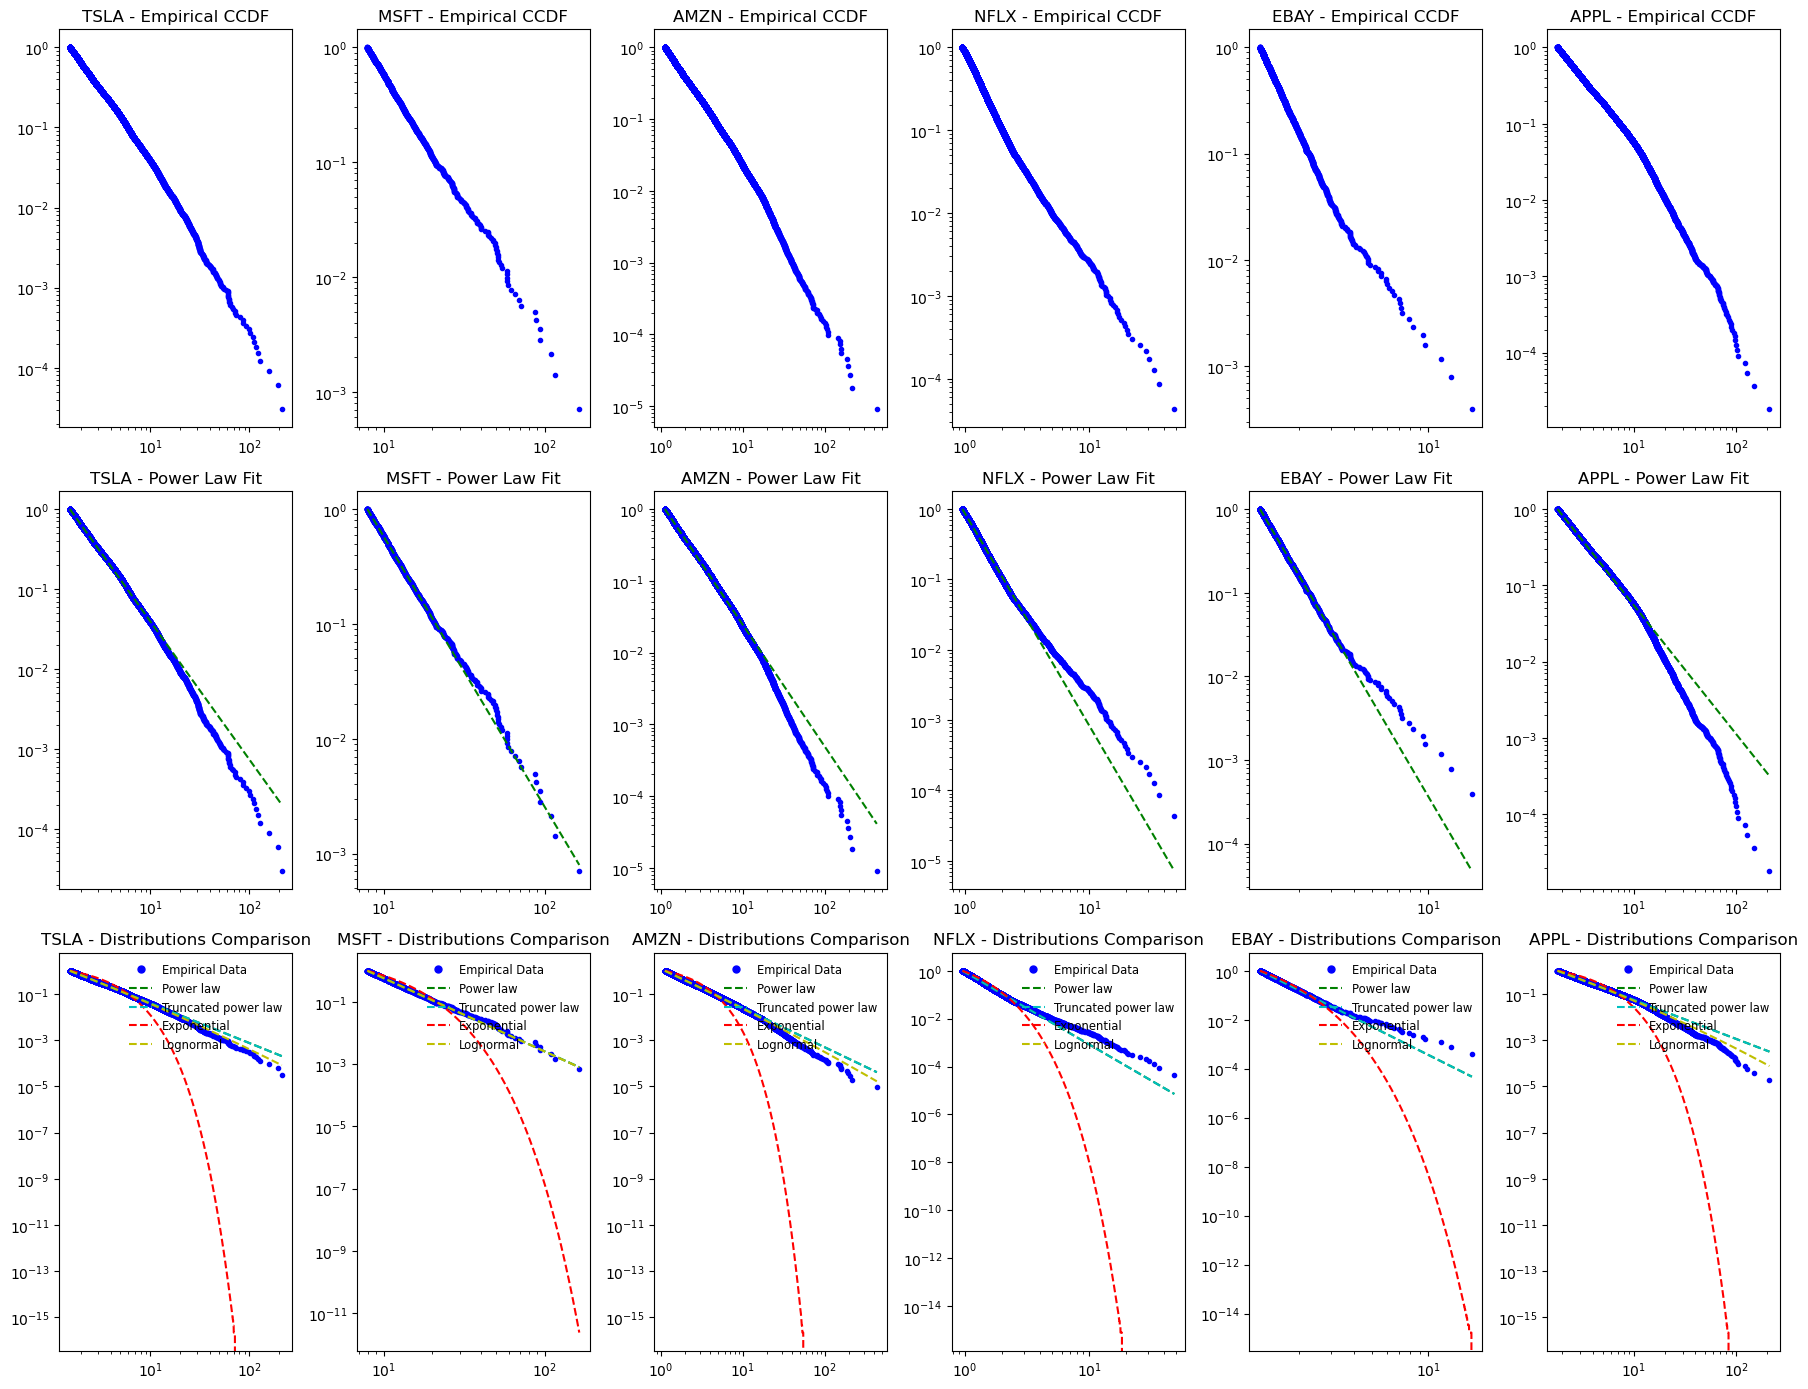

In [10]:
# Plot fitted objects
plot_fit_objects(volume_fit_objects)

#### 1.2.1 Retrieve Power law fitting results

In [11]:
# Get power_law fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'power_law')
print(volume_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  2.722773  1.540715     0.011721
1  MSFT    power_law  3.354121  7.919459     0.013097
2  AMZN    power_law  2.695471  1.122293     0.013441
3  NFLX    power_law  4.008653  0.951052     0.012920
4  EBAY    power_law  4.782494  1.237831     0.012219
5  APPL    power_law  2.694075  1.810834     0.010686


In [12]:
# Average Alpha exponents across stocks
min_alpha = volume_fit_results['alpha'].min()
max_alpha = volume_fit_results['alpha'].max()
avg_alpha = volume_fit_results['alpha'].mean()
std_dev_alpha = volume_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.694075328696667
Max Alpha: 4.782494287979546
Average Alpha: 3.376264521615182
std_dev_alpha: 0.8641529014652487


In [13]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'truncated_power_law')
print(volume_fit_results)

  Stock         Distribution     alpha        Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  2.645100  1.137902e-02  1.540715     0.014508
1  MSFT  truncated_power_law  3.348759  2.262847e-04  7.919459     0.013339
2  AMZN  truncated_power_law  2.638552  1.078603e-02  1.122293     0.017913
3  NFLX  truncated_power_law  4.008576  2.203010e-08  0.951052     0.012913
4  EBAY  truncated_power_law  4.782459  1.502989e-10  1.237831     0.012223
5  APPL  truncated_power_law  2.537125  2.070071e-02  1.810834     0.012056


In [14]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'exponential')
print(volume_fit_results)

  Stock Distribution    Lambda      xmin  KS Distance
0  TSLA  exponential  0.518868  1.540715     0.175657
1  MSFT  exponential  0.171546  7.919459     0.138776
2  AMZN  exponential  0.680300  1.122293     0.189129
3  NFLX  exponential  2.026850  0.951052     0.107047
4  EBAY  exponential  2.183755  1.237831     0.088718
5  APPL  exponential  0.444816  1.810834     0.166006


#### 1.2.2. Compare alternative distributions

In [15]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_comparison = distribution_compare(volume_fit_objects, 'exponential')
display(volume_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,0.518868,1.540715,2.722773,0.011721,0.175657,22.461650,9.846406e-112
1,MSFT,exponential,0.171546,7.919459,3.354121,0.013097,0.138776,5.871538,4.317710e-09
2,AMZN,exponential,0.680300,1.122293,2.695471,0.013441,0.189129,38.147880,0.000000e+00
3,NFLX,exponential,2.026850,0.951052,4.008653,0.012920,0.107047,13.586315,4.827797e-42
4,EBAY,exponential,2.183755,1.237831,4.782494,0.012219,0.088718,4.812927,1.487356e-06
5,APPL,exponential,0.444816,1.810834,2.694075,0.010686,0.166006,32.544466,2.507454e-232


## 2. Signed Ordeflow Imbalance

In [16]:
# Aggregate orderflow
tsla_aggregate_orderflow = compute_aggregate_features(tsla_raw_df, [T], remove_outliers=False)
msft_aggregate_orderflow = compute_aggregate_features(msft_raw_df, [T], remove_outliers=False)
amzn_aggregate_orderflow = compute_aggregate_features(amzn_raw_df, [T], remove_outliers=False)
nflx_aggregate_orderflow = compute_aggregate_features(nflx_raw_df, [T], remove_outliers=False)
ebay_aggregate_orderflow = compute_aggregate_features(ebay_raw_df, [T], remove_outliers=False)
appl_aggregate_orderflow = compute_aggregate_features(appl_raw_df, [T], remove_outliers=False)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}


# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'],
 'MSFT': msft_aggregate_orderflow['vol_imbalance'],
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'],
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'],
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'],
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}
#volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

### Stationarity Tests

In [17]:
# sign_imbalance ADF test
print('Order-sign Imbalance')
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)
print('\n')


Order-sign Imbalance
TSLA
ADF: -5.67
p-value: 0.00,
N: 750, 
critical values: {'1%': -3.439099096730074, '5%': -2.8654013553540745, '10%': -2.568826193777778}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -12.72
p-value: 0.00,
N: 1524, 
critical values: {'1%': -3.4346481290263013, '5%': -2.8634383565975736, '10%': -2.567780658251872}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -7.09
p-value: 0.00,
N: 1007, 
critical values: {'1%': -3.436860474327014, '5%': -2.8644144230916537, '10%': -2.568300476140699}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -11.86
p-value: 0.00,
N: 1627, 
critical values: {'1%': -3.4343755975140455, '5%': -2.8633180685073194, '10%': -2.5677166050955584}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stati

In [18]:
# volume_imbalance ADF test
print('Signed-volume Imbalance')
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

Signed-volume Imbalance
TSLA
ADF: -13.81
p-value: 0.00,
N: 756, 
critical values: {'1%': -3.439029421541435, '5%': -2.8653706489231876, '10%': -2.568809835460933}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -17.21
p-value: 0.00,
N: 1526, 
critical values: {'1%': -3.4346424863111396, '5%': -2.8634358661653803, '10%': -2.5677793320839823}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -13.82
p-value: 0.00,
N: 1013, 
critical values: {'1%': -3.436821814402523, '5%': -2.8643973728364043, '10%': -2.5682913948189823}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -9.04
p-value: 0.00,
N: 1610, 
critical values: {'1%': -3.4344181718827462, '5%': -2.8633368604103104, '10%': -2.567726611627638}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be 

### 2.1. Order Sign Imbalance

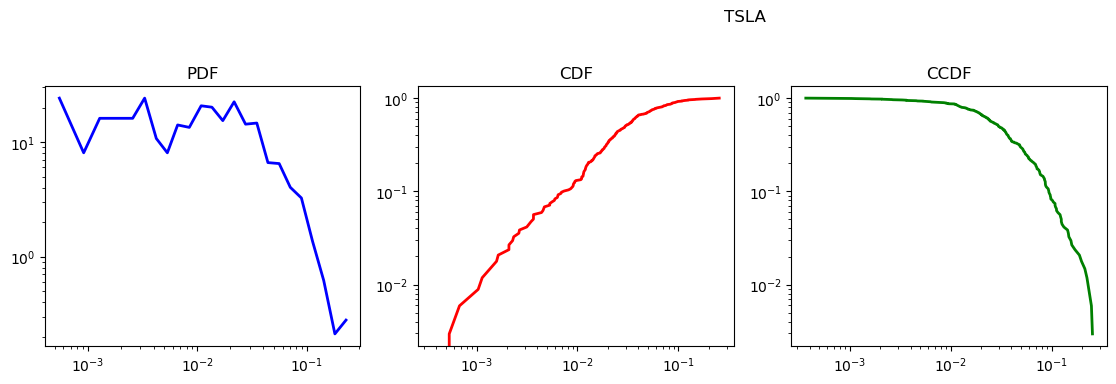

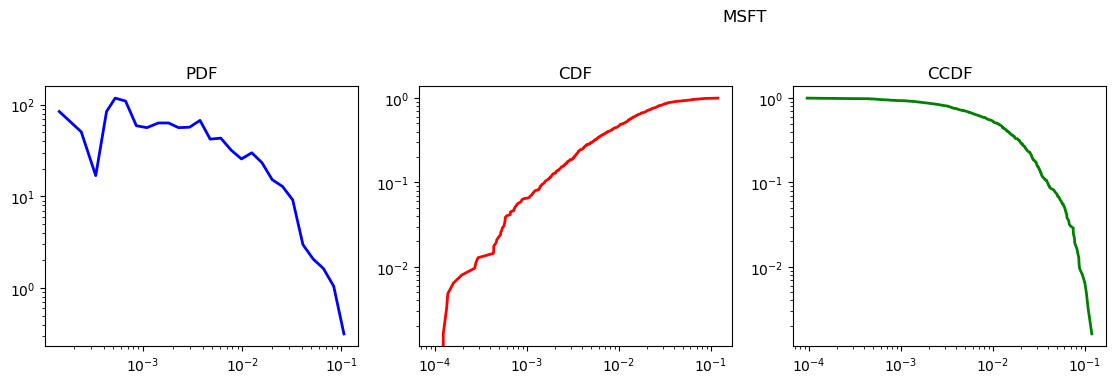

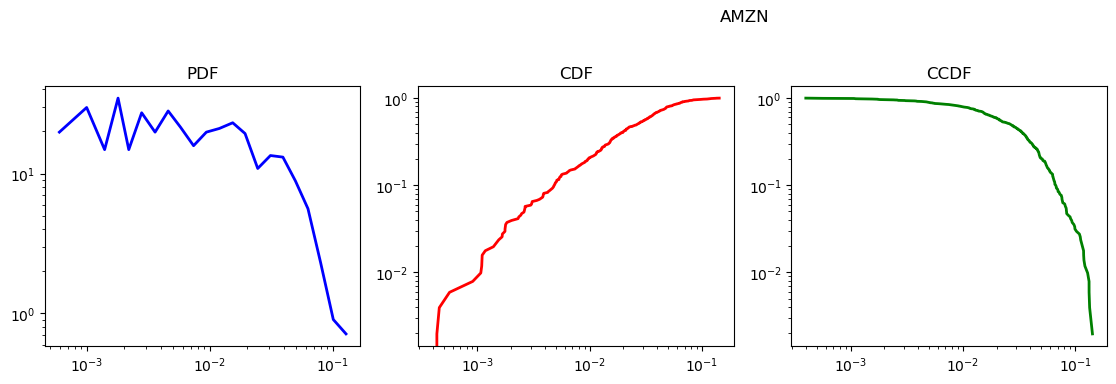

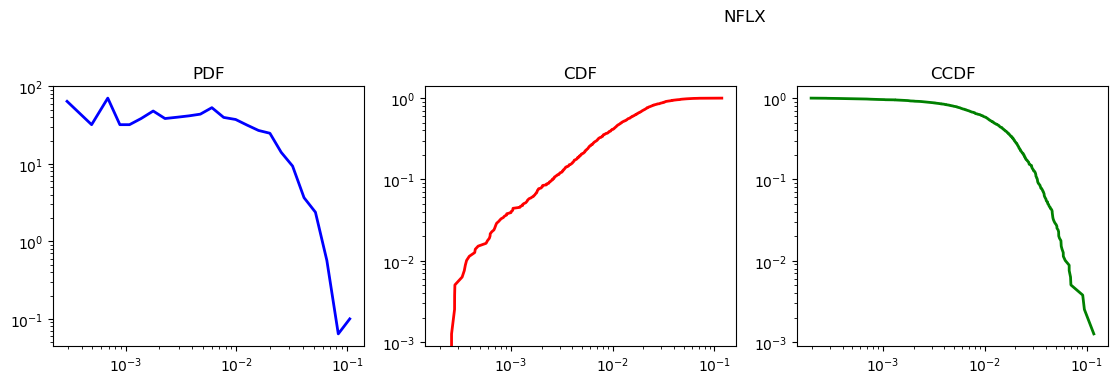

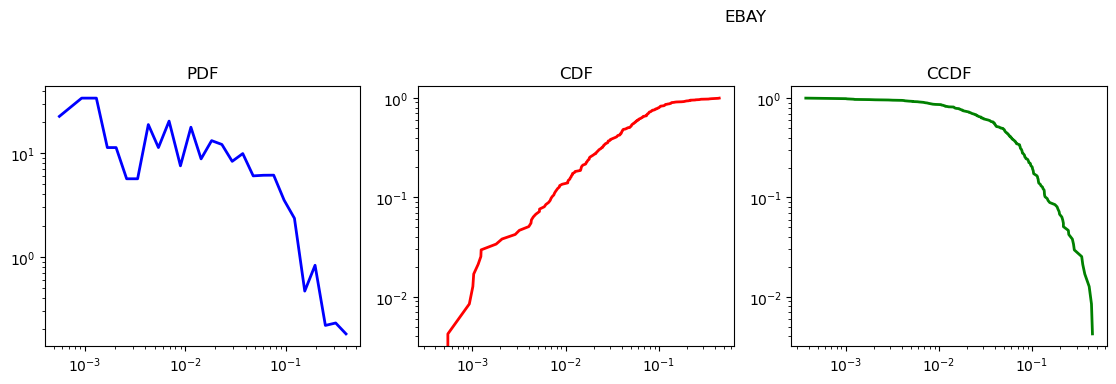

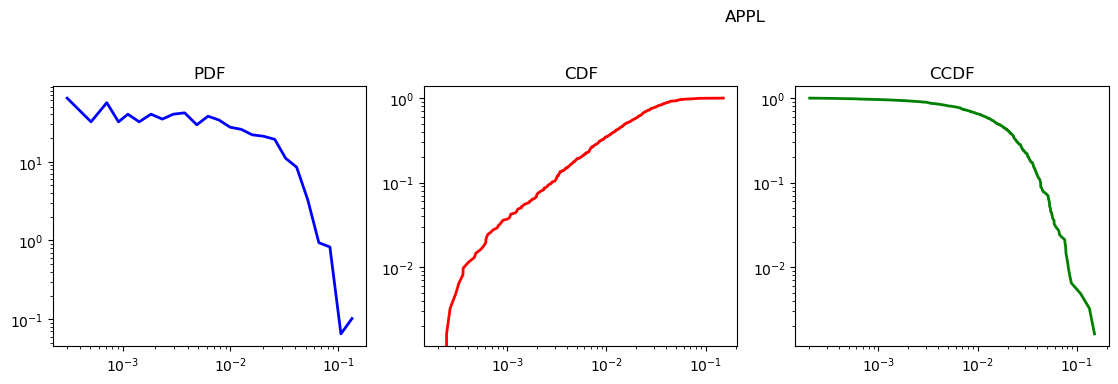

In [19]:
# Plot distribution of sign_imbalance for each stock
for stock_name, data in sign_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.1.1. Fit power law distribution

In [20]:
# 1. Fit Powerlaw and retrieve fitted object/ results
sign_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_sign_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(sign_imbalance_data):
    sign_imbalance_fit_objects = fit_powerlaw(data_dict=sign_imbalance, filename=sign_imbalance_data)
else:
    sign_imbalance_fit_objects = load_fit_objects(sign_imbalance_data)

sign_imbalance_fit_objects

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


{'TSLA': <powerlaw.Fit at 0x293d788d0>,
 'MSFT': <powerlaw.Fit at 0x2ad3aad90>,
 'AMZN': <powerlaw.Fit at 0x2ad3a9490>,
 'NFLX': <powerlaw.Fit at 0x2ad3a88d0>,
 'EBAY': <powerlaw.Fit at 0x2ad3aa110>,
 'APPL': <powerlaw.Fit at 0x2ad3ab890>}

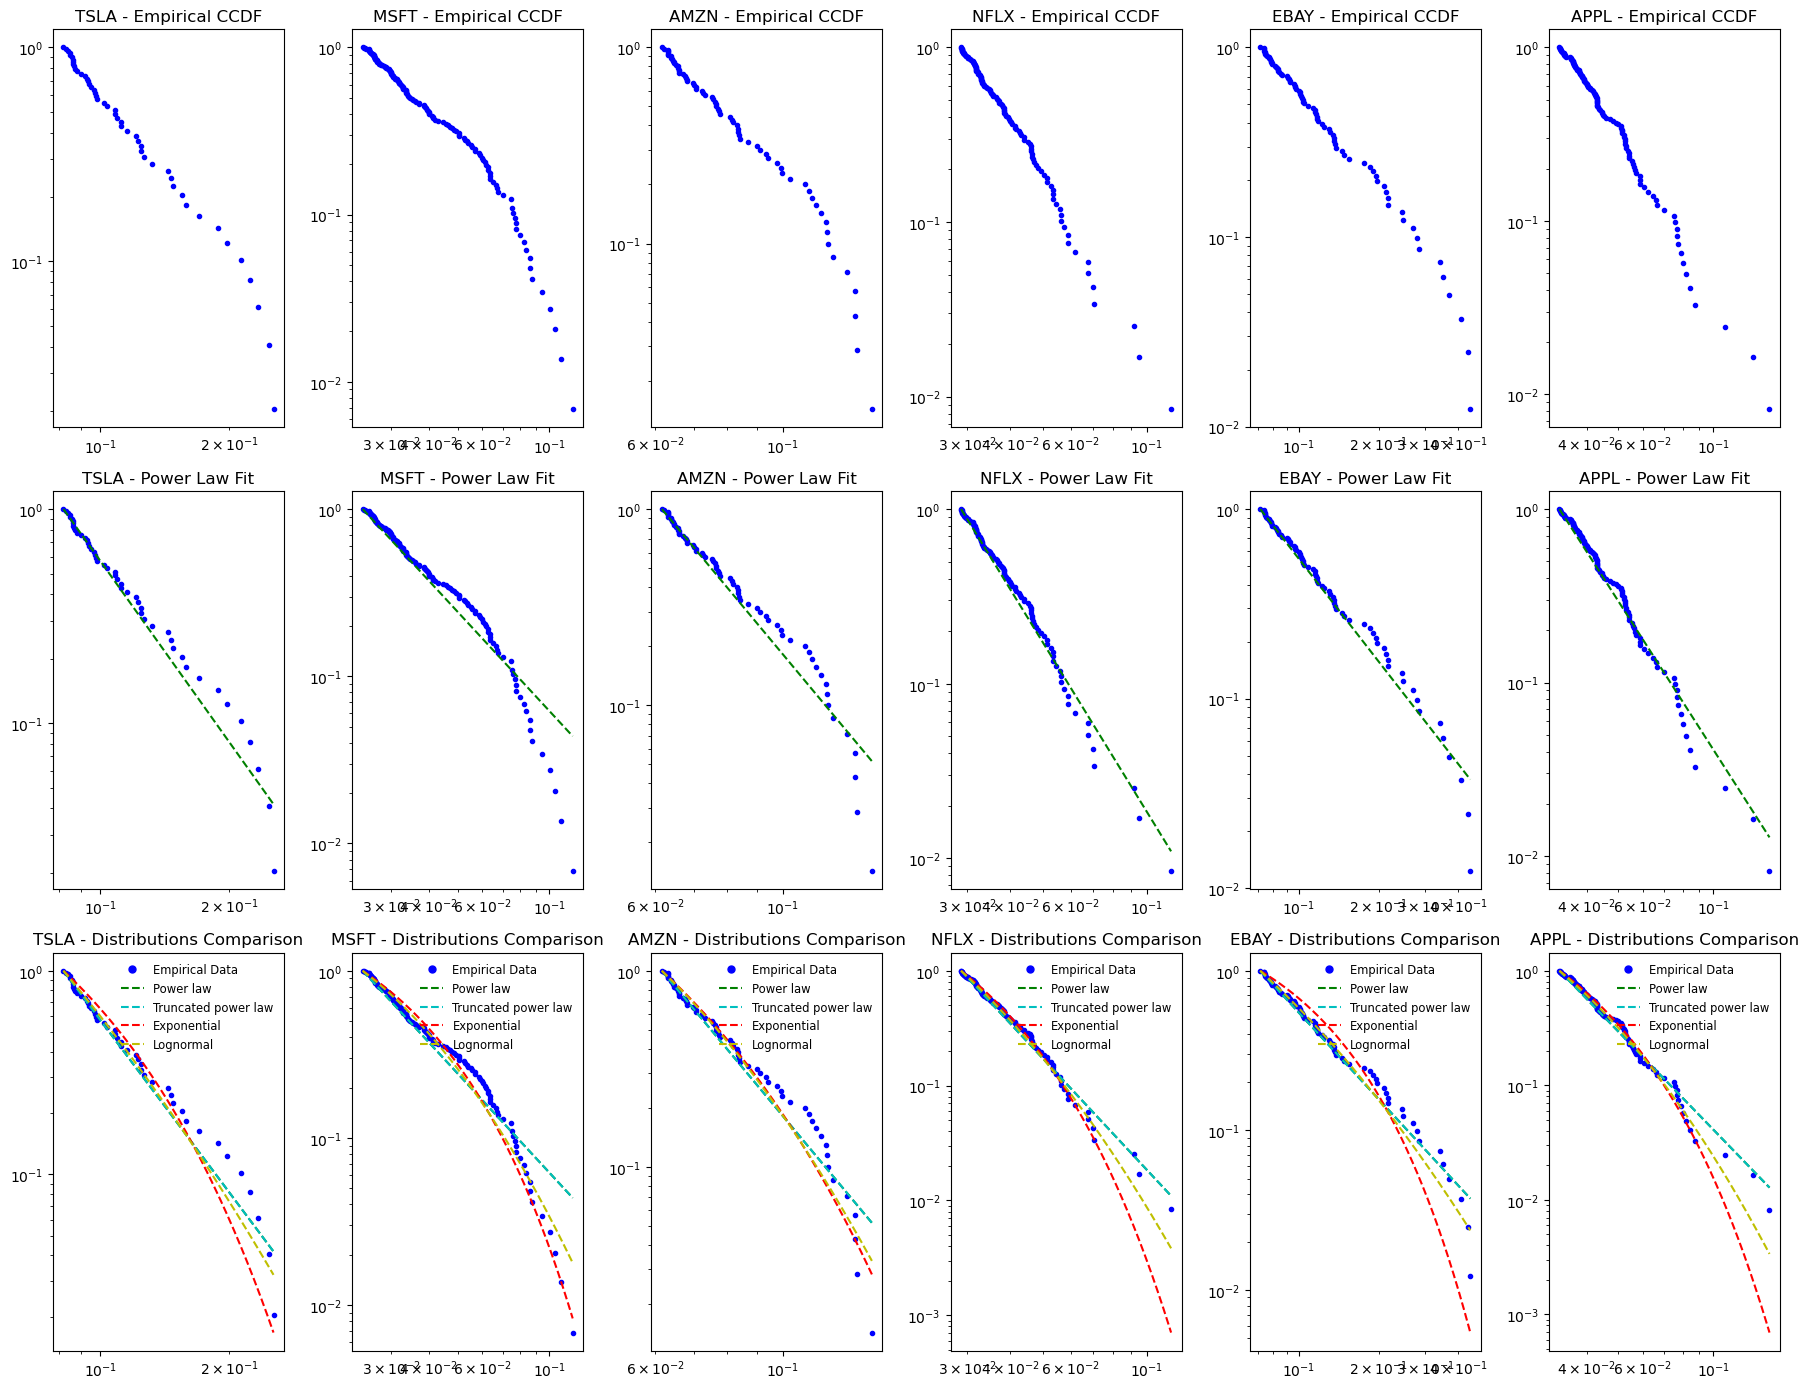

In [21]:
# Plot fitted objects
plot_fit_objects(sign_imbalance_fit_objects)

#### 2.1.2. Retrieve Power law fitting results

In [22]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'power_law')
print(sign_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.813733  0.082103     0.058782
1  MSFT    power_law  2.959584  0.024173     0.068939
2  AMZN    power_law  4.518244  0.061538     0.067072
3  NFLX    power_law  4.195677  0.028738     0.057998
4  EBAY    power_law  2.794505  0.071279     0.054966
5  APPL    power_law  3.863469  0.032782     0.078163


In [23]:
# Average Alpha exponents across stocks
min_alpha = sign_imbalance_fit_results['alpha'].min()
max_alpha = sign_imbalance_fit_results['alpha'].max()
avg_alpha = sign_imbalance_fit_results['alpha'].mean()
std_dev_alpha = sign_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.79450483479269
Max Alpha: 4.518244255936405
Average Alpha: 3.6908684752970427
std_dev_alpha: 0.6815443260808078


In [24]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'truncated_power_law')
print(sign_imbalance_fit_results)

  Stock         Distribution     alpha     Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  2.475784   8.003561  0.082103     0.063851
1  MSFT  truncated_power_law  1.000000  32.416407  0.024173     0.062307
2  AMZN  truncated_power_law  1.000000  33.942984  0.061538     0.075144
3  NFLX  truncated_power_law  2.391326  33.936172  0.028738     0.042019
4  EBAY  truncated_power_law  2.009236   3.565197  0.071279     0.049041
5  APPL  truncated_power_law  1.951732  29.761599  0.032782     0.052934


In [25]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_exp_results = get_fitting_params(sign_imbalance_fit_objects, 'exponential')
print(sign_imbalance_exp_results)

  Stock Distribution     Lambda      xmin  KS Distance
0  TSLA  exponential  23.839487  0.082103     0.111245
1  MSFT  exponential  50.347242  0.024173     0.092780
2  AMZN  exponential  43.914169  0.061538     0.078516
3  NFLX  exponential  81.309438  0.028738     0.074257
4  EBAY  exponential  13.980783  0.071279     0.126115
5  APPL  exponential  61.942786  0.032782     0.073211


#### 2.1.3. Compare alternative distributions

In [26]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
sign_imbalance_comparison = distribution_compare(sign_imbalance_fit_objects, 'exponential')
display(sign_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,23.839487,0.082103,3.813733,0.058782,0.111245,0.243533,0.807593
1,MSFT,exponential,50.347242,0.024173,2.959584,0.068939,0.092780,-1.472523,0.140880
2,AMZN,exponential,43.914169,0.061538,4.518244,0.067072,0.078516,-1.058807,0.289688
3,NFLX,exponential,81.309438,0.028738,4.195677,0.057998,0.074257,0.005956,0.995248
4,EBAY,exponential,13.980783,0.071279,2.794505,0.054966,0.126115,0.795854,0.426117
5,APPL,exponential,61.942786,0.032782,3.863469,0.078163,0.073211,-0.218746,0.826848


### 2.2. Volume Imbalance

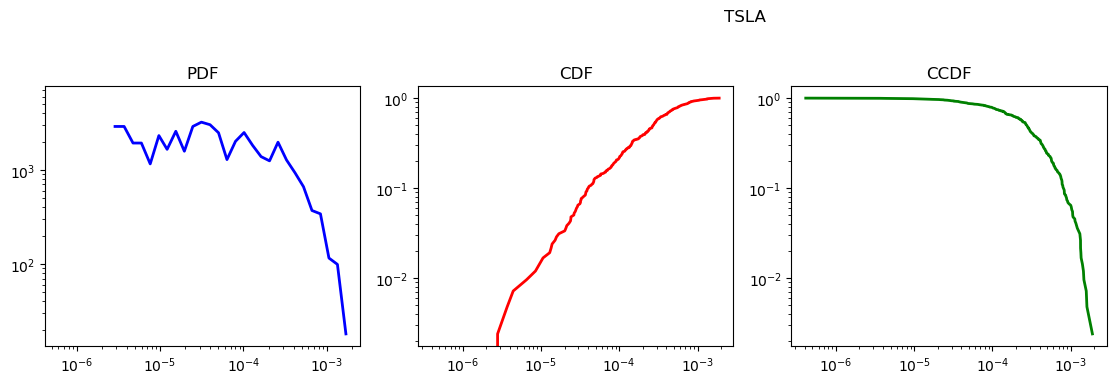

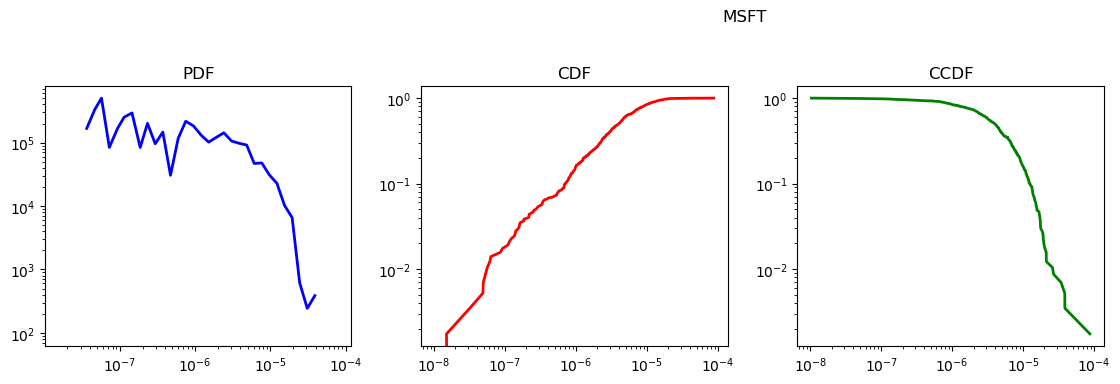

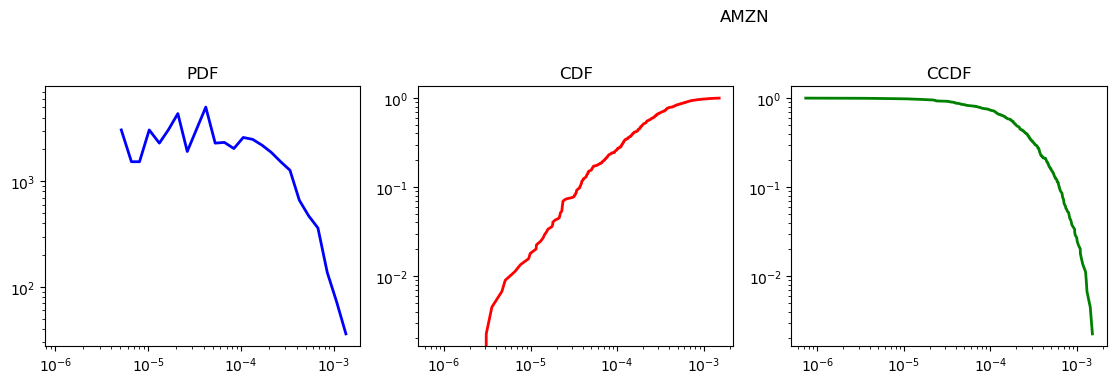

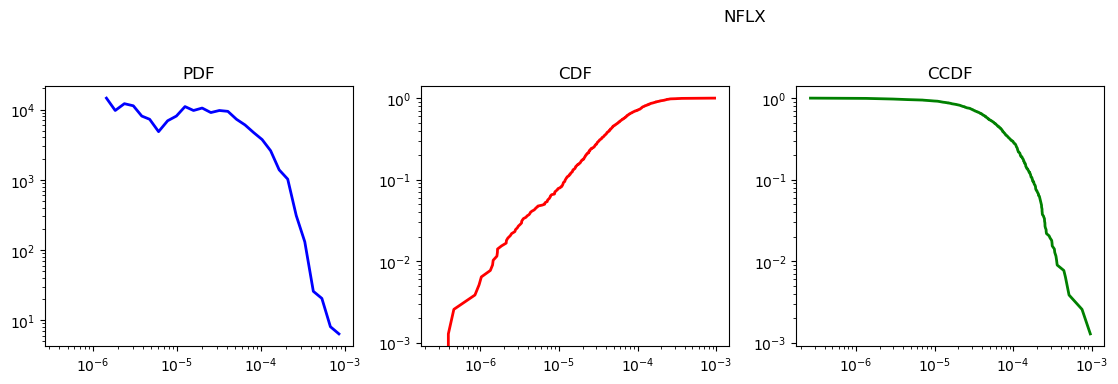

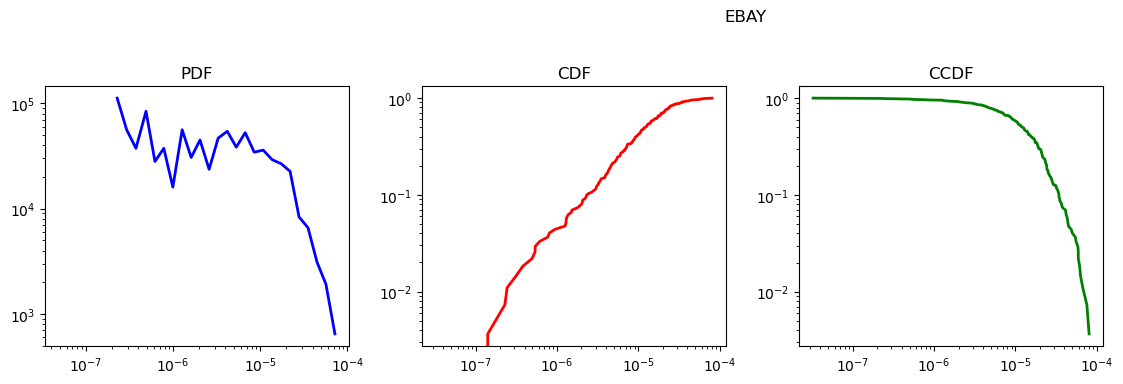

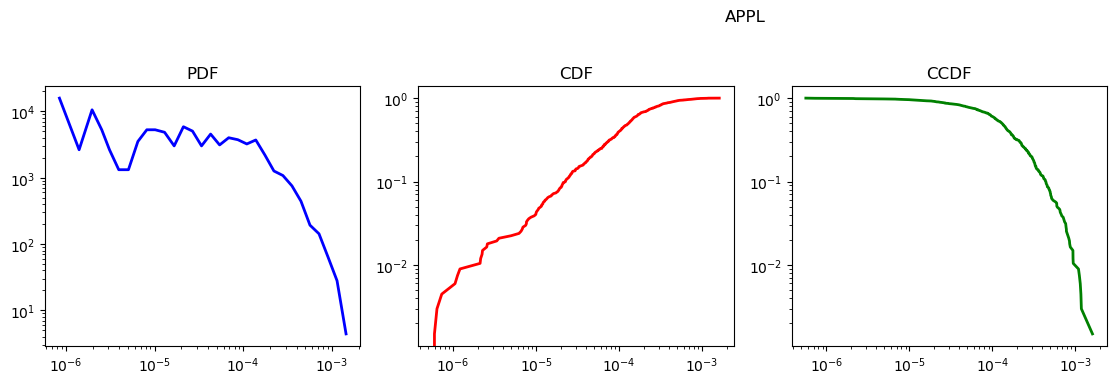

In [27]:
# Plot distribution of volume_imbalance for each stock
for stock_name, data in volume_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.2.1. Fit power law distribution

In [28]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volume_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_volume_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volume_imbalance_data):
    volume_imbalance_data_fit_objects = fit_powerlaw(data_dict=volume_imbalance, filename=volume_imbalance_data)
else:
    volume_imbalance_data_fit_objects = load_fit_objects(volume_imbalance_data)

volume_imbalance_data_fit_objects

Calculating best minimal value for power law fit


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x2ad623b90>,
 'MSFT': <powerlaw.Fit at 0x293ed2950>,
 'AMZN': <powerlaw.Fit at 0x293ee63d0>,
 'NFLX': <powerlaw.Fit at 0x29e5b2a50>,
 'EBAY': <powerlaw.Fit at 0x29e5926d0>,
 'APPL': <powerlaw.Fit at 0x29eb07ad0>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


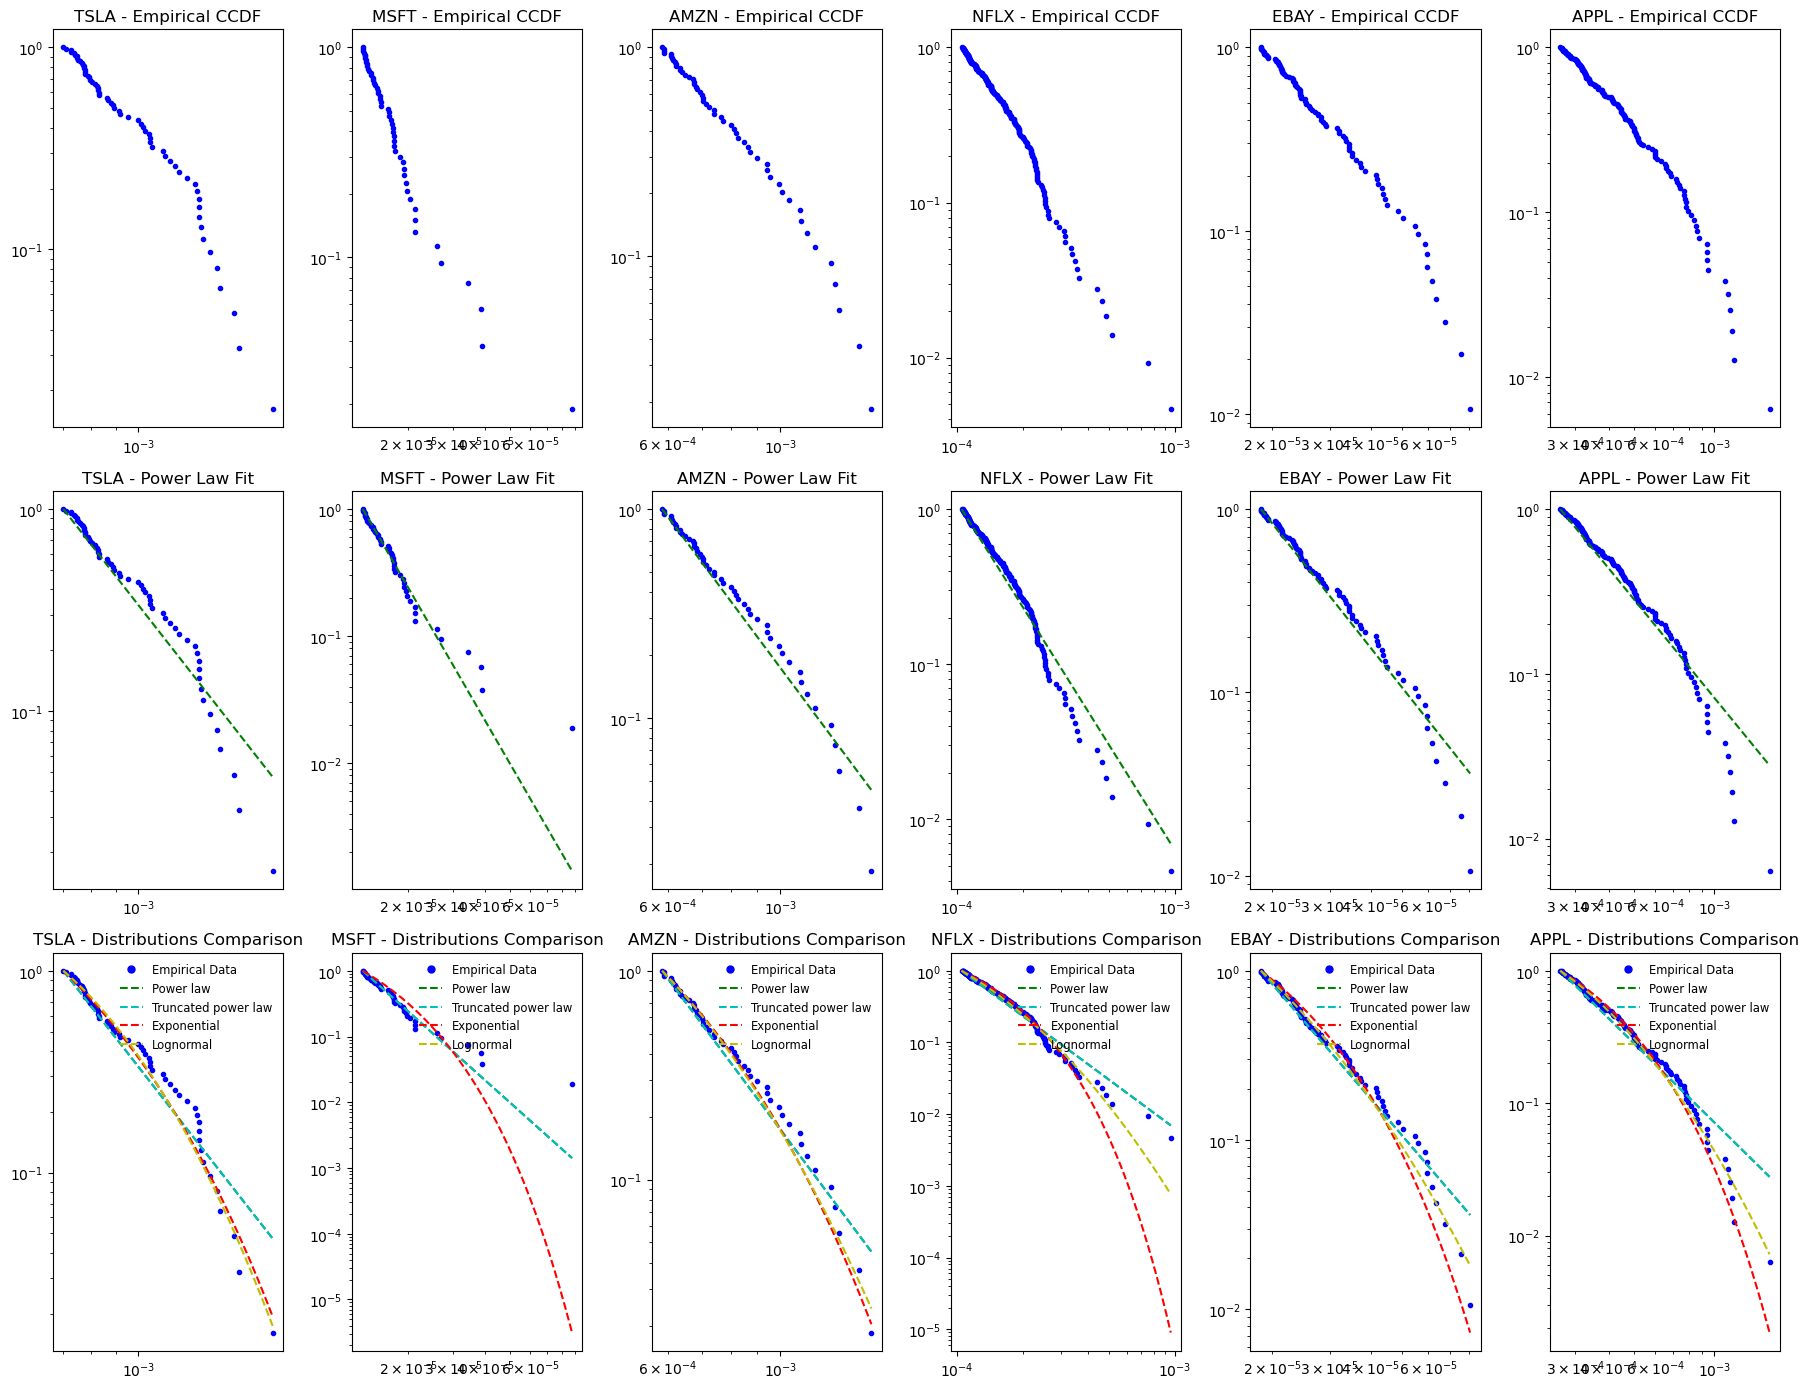

In [29]:
# Plot fitted objects
plot_fit_objects(volume_imbalance_data_fit_objects)

#### 2.2.2. Retrieve Power law fitting results

In [30]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'power_law')
print(volume_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  4.077860  0.000700     0.098852
1  MSFT    power_law  4.479644  0.000013     0.061927
2  AMZN    power_law  4.268800  0.000585     0.070151
3  NFLX    power_law  3.248452  0.000105     0.070630
4  EBAY    power_law  3.249998  0.000018     0.072017
5  APPL    power_law  2.975266  0.000263     0.076688


In [31]:
# Average Alpha exponents across stocks
min_alpha = volume_imbalance_fit_results['alpha'].min()
max_alpha = volume_imbalance_fit_results['alpha'].max()
avg_alpha = volume_imbalance_fit_results['alpha'].mean()
std_dev_alpha = volume_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.975266218090934
Max Alpha: 4.479644094618767
Average Alpha: 3.7166701010396164
std_dev_alpha: 0.6331074855000157


In [32]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'truncated_power_law')
print(volume_imbalance_fit_results)

  Stock         Distribution     alpha        Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  1.000000   2477.442572  0.000700     0.073152
1  MSFT  truncated_power_law  4.479618      0.000004  0.000013     0.061924
2  AMZN  truncated_power_law  1.000000   3201.136493  0.000585     0.057170
3  NFLX  truncated_power_law  1.999186   4969.514076  0.000105     0.039581
4  EBAY  truncated_power_law  1.590371  38867.395199  0.000018     0.049661
5  APPL  truncated_power_law  1.091926   2860.893034  0.000263     0.053017


In [33]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'exponential')
print(volume_imbalance_fit_results)

  Stock Distribution         Lambda      xmin  KS Distance
0  TSLA  exponential    3316.052624  0.000700     0.075452
1  MSFT  exponential  171092.793542  0.000013     0.139413
2  AMZN  exponential    4215.319677  0.000585     0.054152
3  NFLX  exponential   13651.757052  0.000105     0.062644
4  EBAY  exponential   79127.344089  0.000018     0.091342
5  APPL  exponential    4662.187629  0.000263     0.085278


#### 2.2.3. Compare alternative distributions

In [34]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_imbalance_comparison = distribution_compare(volume_imbalance_data_fit_objects, 'exponential')
display(volume_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,3316.052624,0.000700,4.077860,0.098852,0.075452,-1.992370,0.046330
1,MSFT,exponential,171092.793542,0.000013,4.479644,0.061927,0.139413,1.523409,0.127656
2,AMZN,exponential,4215.319677,0.000585,4.268800,0.070151,0.054152,-1.055462,0.291214
3,NFLX,exponential,13651.757052,0.000105,3.248452,0.070630,0.062644,0.154582,0.877151
4,EBAY,exponential,79127.344089,0.000018,3.249998,0.072017,0.091342,-0.405783,0.684902
5,APPL,exponential,4662.187629,0.000263,2.975266,0.076688,0.085278,-1.228651,0.219203
